In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [3]:
EPOCHS     = 40
BATCH_SIZE = 64

In [4]:
transform_CIFAR10 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root      = './data_CIFAR10', 
        train     = True,
        download  = True,
        transform = transform_CIFAR10),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root      = './data_CIFAR10', 
        train     = False,
        download  = True,
        transform = transform_CIFAR10),
    batch_size=BATCH_SIZE,
    shuffle=True
)


Extracting ./data_CIFAR10/cifar-10-python.tar.gz to ./data_CIFAR10
Files already downloaded and verified


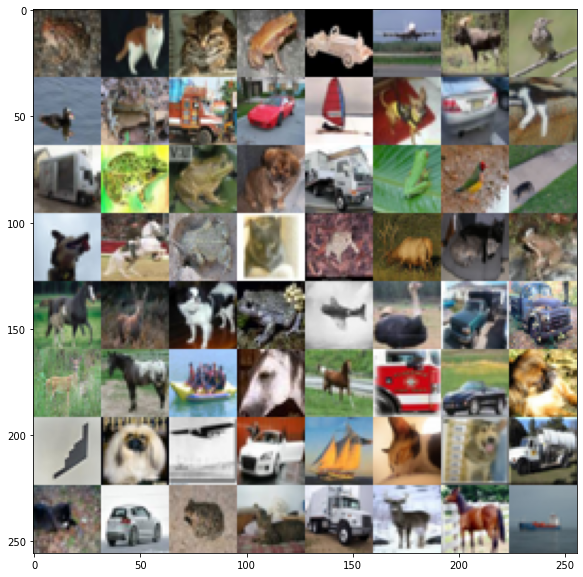

[[' frog' '  cat' '  cat' ' frog' '  car' 'plane' ' deer' ' bird']
 [' bird' ' frog' 'truck' '  car' ' ship' '  dog' '  car' '  cat']
 ['truck' ' frog' ' frog' '  dog' 'truck' ' frog' ' bird' '  cat']
 ['  dog' 'horse' ' frog' '  cat' ' frog' ' deer' '  cat' ' frog']
 ['horse' ' deer' '  dog' ' frog' 'plane' ' bird' 'truck' 'truck']
 [' deer' 'horse' ' ship' 'horse' 'horse' 'truck' '  car' '  dog']
 ['plane' '  dog' 'plane' '  car' ' ship' '  cat' '  dog' 'truck']
 ['  cat' '  car' ' frog' '  cat' 'truck' ' deer' 'horse' ' ship']]


In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()
classes = np.array(['plane', '  car', ' bird', '  cat', ' deer',
                    '  dog', ' frog', 'horse', ' ship', 'truck'])
print(classes[labels.reshape((8, 8))])

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 24, kernel_size=3)
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(4056, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = x.view(-1, 4056)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

# **The VGG network structure**


*   The input of VGG is set to an RGB image of 224x244 size. The average RGB value is calculated for all images on the training set image, and then the image is input as an input to the VGG convolution network. A 3x3 or 1x1 filter is used, and the convolution step is fixed. . There are 3 VGG fully connected layers, which can vary from VGG11 to VGG19 according to the total number of convolutional layers + fully connected layers. The minimum VGG11 has 8 convolutional layers and 3 fully connected layers. The maximum VGG19 has 16 convolutional layers. +3 fully connected layers. In addition, the VGG network is not followed by a pooling layer behind each convolutional layer, or a total of 5 pooling layers distributed under different convolutional layers. The following figure is VGG Structure diagram:




![vgg.png](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/vgg.png)

![vggarc.png](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/network.png)



*   VGG16 contains 16 layers and VGG19 contains 19 layers. A series of VGGs are exactly the same in the last three fully connected layers. The overall structure includes 5 sets of convolutional layers, followed by a MaxPool. The difference is that more and more cascaded convolutional layers are included in the five sets of convolutional layers.



![vggtable.png](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/config2.jpg)



*   Each convolutional layer in AlexNet contains only one convolution, and the size of the convolution kernel is 7x7, In VGGNet, each convolution layer contains 2 to 4 convolution operations. The size of the convolution kernel is 3x3, the convolution step size is 1, the pooling kernel is 2x2, and the step size is 2. The most obvious improvement of VGGNet is to reduce the size of the convolution kernel and increase the number of convolution layers.



![vggcnn](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/config3.jpg)

**VGG Network Configuration**

Table 1 shows all network configurations. These networks follow the same design principles, but differ in depth.

![vggpaper](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/netconvgg.png)

In [7]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

test()

torch.Size([2, 10])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# **The ResNet structure**

ResNet, short for Residual Network is a specific type of neural network that was introduced in 2015 by Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun in their paper “Deep Residual Learning for Image Recognition. The ResNet models were extremely successful which you can guess from the following:

* Won 1st place in the ILSVRC 2015 classification competition with a top-5 error rate of 3.57% (An ensemble model)
* Won the 1st place in ILSVRC and COCO 2015 competition in ImageNet Detection, ImageNet localization, Coco detection and Coco segmentation.
* Replacing VGG-16 layers in Faster R-CNN with ResNet-101. They observed relative improvements of 28%
* Efficiently trained networks with 100 layers and 1000 layers also.

![Residual Block](https://media.geeksforgeeks.org/wp-content/uploads/20200424011510/Residual-Block.PNG)

**Residual Block:**

*   In order to solve the problem of the vanishing/exploding gradient, this architecture introduced the concept called Residual Network. In this network we use a technique called skip connections . The skip connection skips training from a few layers and connects directly to the output.

* The approach behind this network is instead of layers learn the underlying mapping, we allow network fit the residual mapping. So, instead of say H(x), initial mapping, let the network fit, F(x) := H(x) – x which gives H(x) := F(x) + x

**ResNet architecture**

ResNet network uses a 34-layer plain network architecture inspired by VGG-19 in which then the shortcut connection is added. These shortcut connections then convert the architecture into the residual network as shown in the figure below:

![ResNetarc](https://d1m75rqqgidzqn.cloudfront.net/wp-data/2020/09/09194511/0_Si4ckM1MrkUxTaDH.png)

In [13]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

![Residual Block](https://t1.daumcdn.net/cfile/tistory/9907E0375CB8A11F0F)

In [14]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [21]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


![ResNetpaperarc](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FzwdXd%2FbtqzVoeJwoE%2F9oMcs2Qkj5m07pKPHRmeK0%2Fimg.png)

In [22]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

test()

torch.Size([1, 10])


In [23]:
# model     = CNN().to(DEVICE)
# model = VGG('VGG11').to(DEVICE)
model = ResNet18().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [24]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [25]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [26]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.424181
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.382981
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.064369
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.836873
[1] Test Loss: 1.1135, Accuracy: 60.19%
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.069894
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.099076
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.935569
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.102370
[2] Test Loss: 1.5020, Accuracy: 53.57%
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.410934
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.619238
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.640258
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.399150
[3] Test Loss: 1.1048, Accuracy: 66.80%
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.460797
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.354531
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.406879
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.558975
[4] Test Loss: 0.9305, Accuracy: 70.15%
Train Epoch: 5 [0/50000 (0%)]	Loss: 0.242866
Train Epoch: 5 

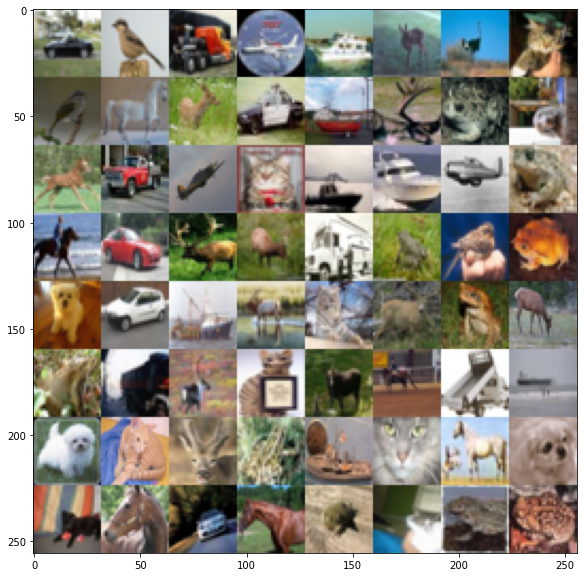

your predict : 
[['  car' ' bird' 'truck' ' bird' ' ship' ' deer' ' deer' '  cat']
 [' bird' 'horse' ' deer' 'truck' ' ship' ' deer' ' frog' '  cat']
 [' deer' '  car' 'plane' '  cat' ' ship' ' ship' 'plane' ' frog']
 ['horse' '  car' ' deer' ' deer' 'truck' ' bird' ' bird' ' frog']
 ['  dog' '  car' ' ship' 'horse' ' frog' ' deer' ' frog' ' deer']
 [' frog' 'truck' ' deer' '  cat' ' deer' 'horse' '  cat' 'plane']
 ['  dog' '  cat' ' deer' ' frog' ' ship' '  cat' 'horse' '  dog']
 ['  cat' 'horse' '  car' 'horse' ' frog' '  cat' ' frog' ' frog']]

answer : 
[['  car' ' bird' 'truck' 'plane' ' ship' ' deer' ' bird' '  cat']
 [' bird' 'horse' ' deer' '  car' ' ship' ' deer' ' frog' '  dog']
 ['horse' 'truck' 'plane' '  cat' ' ship' ' ship' 'plane' ' frog']
 ['horse' '  car' ' deer' ' deer' 'truck' ' frog' ' bird' ' frog']
 ['  dog' '  car' ' ship' ' deer' '  cat' ' deer' ' frog' ' deer']
 [' frog' 'truck' ' deer' '  cat' ' deer' 'horse' 'truck' ' ship']
 ['  dog' '  cat' ' deer' ' frog' 

In [27]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()
your_predict = model(images.to(DEVICE)).max(1)[1].view(8, 8).cpu()
answer = labels.reshape((8, 8))
correct = your_predict == answer
print("your predict : ")
print(classes[your_predict])
print("\nanswer : ")
print(classes[answer])
print("\ncorrectness :", correct.sum().item()/64)
print(correct)